In [165]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [166]:
###Automatic detection of tuberculosis by fluorography
image_size = 299
batch_size = 32

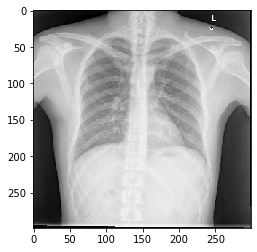

In [167]:
###Data were taken from https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1
img_path = 'base_dir/train_dir/Normal/CHNCXR_0163_0.png'
img = tf.compat.v1.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [168]:
###Create image generators
###Training Data Catalog
train_dir = 'base_dir/train_dir'
test_dir = 'base_dir/val_dir'
###Image-based tensor dimension for input to a neural network
input_shape = (image_size, image_size, 3)

In [169]:
###Generator with data addition
train_datagen = tf.compat.v1.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

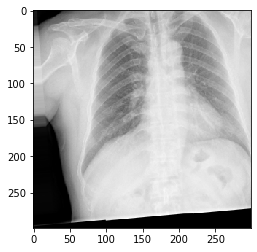

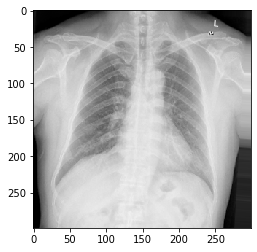

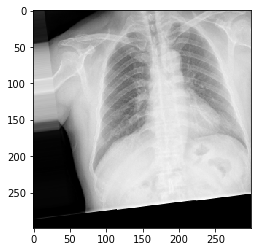

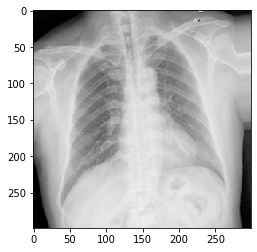

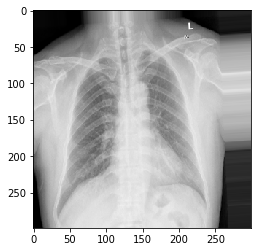

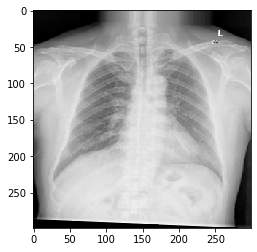

In [170]:
###Check Generator
img_path = 'base_dir/train_dir/Normal/CHNCXR_0001_0.png'
img = tf.compat.v1.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
x = tf.compat.v1.keras.preprocessing.image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [171]:
###Generator for learning
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 680 images belonging to 2 classes.


In [172]:
###Generator for testing without data addition
test_datagen = tf.compat.v1.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [173]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 120 images belonging to 2 classes.


In [174]:
###Class numbers in generators
train_generator.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [175]:
###Loading the pre-trained neural network "Inception"
pretrained_model = tf.compat.v1.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [176]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_474 (BatchN (None, None, None, 3 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_474 (Activation)     (None, None, None, 3 0           batch_normalization_474[0][0]    
_______________________________________________________________________________________

In [177]:
###"Freeze" the weights of a pre-trained neural network
pretrained_model.trainable = False

In [178]:
###Create a composite neural network
x = pretrained_model.output
x = tf.compat.v1.keras.layers.GlobalAveragePooling2D()(x)
x = tf.compat.v1.keras.layers.Dense(512)(x)
x = tf.compat.v1.keras.layers.BatchNormalization()(x)
x = tf.compat.v1.keras.layers.Activation('relu')(x)
x = tf.compat.v1.keras.layers.Dropout(0.5)(x)
predictions = tf.compat.v1.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.compat.v1.keras.models.Model(inputs=pretrained_model.input, outputs=predictions)

In [179]:
###Train a composite neural network based on InceptionV3
model.compile(loss='binary_crossentropy',
              optimizer=tf.compat.v1.keras.optimizers.RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [180]:
filepath="inceptionv3_best.h5"
checkpoint = tf.compat.v1.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
learning_rate_reduction = tf.compat.v1.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [181]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5
Epoch 1/5

Epoch 00001: val_accuracy improved from -inf to 0.52632, saving model to inceptionv3_best.h5
40/40 - 381s - loss: 0.6530 - accuracy: 0.6615 - val_loss: 0.7702 - val_accuracy: 0.5263
Epoch 2/5
Epoch 1/5

Epoch 00002: val_accuracy did not improve from 0.52632
40/40 - 260s - loss: 0.5364 - accuracy: 0.7459 - val_loss: 0.9402 - val_accuracy: 0.4868
Epoch 3/5
Epoch 1/5

Epoch 00003: val_accuracy did not improve from 0.52632
40/40 - 274s - loss: 0.4951 - accuracy: 0.7833 - val_loss: 0.8206 - val_accuracy: 0.5263
Epoch 4/5
Epoch 1/5

Epoch 00004: val_accuracy improved from 0.52632 to 0.53289, saving model to inceptionv3_best.h5
40/40 - 282s - loss: 0.5052 - accuracy: 0.7723 - val_loss: 0.9424 - val_accuracy: 0.5329
Epoch 5/5
Epoch 1/5

Epoch 00005: val_accuracy improved from 0.53289 to 0.55921, saving model to inceptionv3_best.h5
40/40 - 269s - loss: 0.4817 - accuracy: 0.7670 - val_loss: 1.0624 - val_accuracy: 0.5592


In [182]:
###Testing the model
###Loading trained weights
model.load_weights("inceptionv3_best.h5")

In [183]:
###"Defrost" the last two blocks of "Inception"
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [184]:
###Compile a network with defrosted layers
model.compile(loss='binary_crossentropy',
              optimizer=tf.compat.v1.keras.optimizers.RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [185]:
filepath="inceptionv3_fine_tuned.h5"
checkpoint = tf.compat.v1.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
learning_rate_reduction = tf.compat.v1.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [186]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5
Epoch 1/5

Epoch 00001: val_accuracy improved from -inf to 0.59211, saving model to inceptionv3_fine_tuned.h5
40/40 - 352s - loss: 0.4889 - accuracy: 0.7987 - val_loss: 0.6519 - val_accuracy: 0.5921
Epoch 2/5
Epoch 1/5

Epoch 00002: val_accuracy did not improve from 0.59211
40/40 - 345s - loss: 0.3790 - accuracy: 0.8487 - val_loss: 1.1931 - val_accuracy: 0.5526
Epoch 3/5
Epoch 1/5

Epoch 00003: val_accuracy did not improve from 0.59211
40/40 - 330s - loss: 0.3139 - accuracy: 0.8692 - val_loss: 1.9098 - val_accuracy: 0.5000
Epoch 4/5
Epoch 1/5

Epoch 00004: val_accuracy did not improve from 0.59211

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 - 355s - loss: 0.2530 - accuracy: 0.8949 - val_loss: 1.1778 - val_accuracy: 0.5329
Epoch 5/5
Epoch 1/5

Epoch 00005: val_accuracy did not improve from 0.59211
40/40 - 356s - loss: 0.1986 - accuracy: 0.9286 - val_loss: 1.2589 - val_accuracy: 0.5592


In [187]:
###Testing the model
###Loading trained weights
model = tf.compat.v1.keras.models.load_model("inceptionv3_fine_tuned.h5")

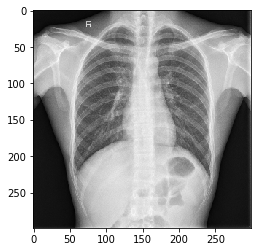

In [188]:
###Upload image
#img_path = 'base_dir/val_dir/Tuberculosis/CHNCXR_0337_1.png'
img_path = 'base_dir/val_dir/Normal/CHNCXR_0171_0.png'
#img_path = 'base_dir/val_dir/Tuberculosis/MCUCXR_0367_1.png'
img = tf.compat.v1.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [189]:
###Convert the image to an array for recognition
x = tf.compat.v1.keras.preprocessing.image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [190]:
###Start recognition
prediction = model.predict(x)

In [191]:
prediction

array([[0.3000869]], dtype=float32)

In [192]:
if prediction[[0]] < 0.5:
    print('Normal')
else:
    print('Tuberculosis')

Normal
